In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean

from mlforecast.target_transforms import Differences

In [15]:
path = '../data'

In [16]:
data = pd.read_csv(os.path.join(path, 'preproc_train.csv'), parse_dates=['Time'])

In [17]:
times = data.Time.unique()

split_time = sorted(list(times))[int(len(times) * 0.8)]
train = data.loc[data['Time'] < split_time]
valid = data.loc[data['Time'] >= split_time]

In [18]:
split_time

Timestamp('2022-08-08 00:00:00')

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from mlforecast import MLForecast

models = [make_pipeline(SimpleImputer(), RandomForestRegressor(random_state=0, n_estimators=100)),
          XGBRegressor(random_state=0, n_estimators=100, tree_method='gpu_hist', gpu_id=0)]


model = MLForecast(models=models,
                   freq='H',
                   lags=[24 * (i+1) for i in range(7)],
                    lag_transforms={
                        24: [(ewm_mean, 0.3)],
                    },
                   num_threads=128)
h = 7 * 24

In [27]:
dynamic_features = ['Temperature', 'Precipitation', 'Wind speed', 'Humidity', 'Sunshine', 'Solar radiation']
static_features = ['building_id', 'Total area', 'Cooling area', 'Solar', 'ESS', 'PCS', 'type_0','type_1', 'type_2', 'type_3',
                   'type_4', 'type_5', 'type_6', 'type_7','type_8', 'type_9', 'type_10', 'type_11']

In [28]:
model.fit(train, id_col='building_id', time_col='Time', target_col='consumption', static_features=static_features, max_horizon=h)

MemoryError: could not allocate 16777216 bytes

In [ ]:
p = model.predict(horizon=h, dynamic_dfs=[valid[['building_id','Time']+dynamic_features]])
p = p.merge(valid[['building_id', 'Time', 'consumption']], on=['building_id', 'Time'], how='left')

In [ ]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
   
print(f"SMAPE Random Forest Pipeline: {smape(p['consumption'], p['Pipeline'])}\nSMAPE XGBRegressor: {smape(p['consumption'], p['XGBRegressor'])}")

SMAPE Random Forest Pipeline: 3.0453974851756715
SMAPE XGBRegressor: 3.81396531406832


<Axes: title={'center': 'Feature Importance XGBRegressor'}>

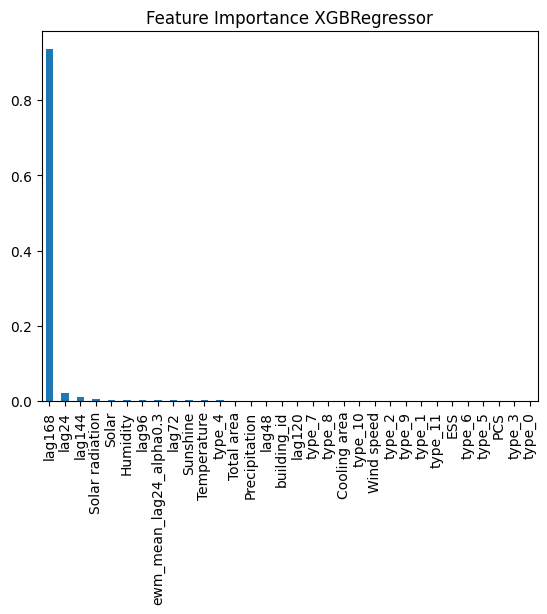

In [24]:
pd.Series(model.models_['XGBRegressor'][0].feature_importances_, index=model.ts.features_order_).sort_values(ascending=False).plot.bar(title='Feature Importance XGBRegressor')

In [ ]:
p.loc['huilding_id' == 1]

,building_id,Time,Pipeline,XGBRegressor,consumption
0,1,2022-08-08 00:00:00,1836.330,1759.146362,2425.92
1,1,2022-08-08 01:00:00,1533.444,1671.968872,2383.20
2,2,2022-08-08 00:00:00,1363.752,1193.295288,1333.80
3,2,2022-08-08 01:00:00,1108.116,1094.197998,1321.92
4,3,2022-08-08 00:00:00,986.184,830.938599,927.00
...,...,...,...,...,...
195,98,2022-08-08 01:00:00,585.003,668.414062,805.32
196,99,2022-08-08 00:00:00,930.546,917.362488,892.26
197,99,2022-08-08 01:00:00,841.800,877.002563,828.90
198,100,2022-08-08 00:00:00,657.669,540.345093,513.84
